# **Simple RNN Exercise 4: Predict Different Variables**

This excercise demonstrates how Simple RNN performs when predicting different weather variables instead of just temperature.

**Import Libraries and Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(" EXERCISE 4: PREDICT DIFFERENT VARIABLES")
print("=" * 60)
print("Goal: See how model performs on different weather variables")
print("We'll predict Humidity, Pressure, and WindSpeed instead of Temperature")
print("=" * 60)

 EXERCISE 4: PREDICT DIFFERENT VARIABLES
Goal: See how model performs on different weather variables
We'll predict Humidity, Pressure, and WindSpeed instead of Temperature


**Data Generation Function (Same as Previous Exercises)**

In [2]:
def generate_weather_data(days=500):
    """Generate synthetic weather data with realistic patterns"""
    np.random.seed(42)
    data = []

    for i in range(days):
        # Season calculation (0: spring, 1: summer, 2: fall, 3: winter)
        season = int(i / 91) % 4

        # Base temperature by season
        base_temps = [15, 25, 10, 0]  # Spring, Summer, Fall, Winter
        base_temp = base_temps[season]

        # Add seasonal and daily variations
        seasonal_variation = 5 * np.sin(2 * np.pi * i / 365)
        daily_variation = 3 * np.sin(2 * np.pi * i / 30)  # Monthly cycle
        random_variation = np.random.normal(0, 2)

        temperature = base_temp + seasonal_variation + daily_variation + random_variation

        # Correlated weather variables
        humidity = np.clip(60 + (25 - temperature) * 0.8 + np.random.normal(0, 5), 0, 100)
        pressure = 1013 + np.random.normal(0, 15) + temperature * 0.1
        wind_speed = np.clip(8 + np.random.exponential(5) + abs(temperature - 15) * 0.1, 0, 30)

        data.append({
            'Day': i,
            'Temperature': temperature,
            'Humidity': humidity,
            'Pressure': pressure,
            'WindSpeed': wind_speed,
            'Season': season
        })

    return pd.DataFrame(data)

**Data Preparation Function (Variable Target Column)**

In [3]:
def prepare_data_for_simple_rnn(data, sequence_length=7, feature_columns=None, target_column='Temperature'):
    """
     KEY FUNCTION: Prepare data for Simple RNN training
    For Exercise 4: We vary target_column to predict different variables
    """
    if feature_columns is None:
        feature_columns = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

    print(f" Preparing data with sequence_length={sequence_length}")
    print(f" Features: {feature_columns}")
    print(f" Number of features: {len(feature_columns)}")
    print(f" Target: {target_column}")

    # Extract features and target
    features = data[feature_columns].values
    target = data[target_column].values.reshape(-1, 1)

    # Normalize data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    print(f" Data shape: X={X.shape}, y={y.shape}")
    print(f" Available samples: {len(X)}")

    return X, y, scaler_features, scaler_target

**Model Creation Function (Fixed Architecture)**

Purpose: Model creation with fixed architecture using optimal hyperparameters from previous exercises.

In [4]:
def create_simple_rnn_model(input_shape, hidden_units=32):
    """
    Create Simple RNN model
    Using optimal settings from previous exercises
    """
    print(f" Creating Simple RNN model:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Hidden units: {hidden_units}")
    print(f"   - Number of input features: {input_shape[1]}")

    model = Sequential([
        SimpleRNN(hidden_units,
                 input_shape=input_shape,
                 activation='tanh',
                 return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

**Training and Evaluation Function**

Purpose: Standard training and evaluation function with fixed parameters from previous exercises.

In [5]:
def train_and_evaluate_model(X, y, scaler_target, hidden_units=32, epochs=40):
    """Train model and return performance metrics"""

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f" Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Create and train model
    model = create_simple_rnn_model(input_shape=(X.shape[1], X.shape[2]), hidden_units=hidden_units)

    print(f" Training model for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0,  # Reduced verbosity
        shuffle=False  # Keep time series order
    )

    # Make predictions
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled)
    y_test_denorm = scaler_target.inverse_transform(y_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test_denorm, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions))

    print(f"✅ Model Performance:")
    print(f"    Mean Absolute Error: {mae:.3f}")
    print(f"    Root Mean Square Error: {rmse:.3f}")

    return mae, rmse, history, predictions, y_test_denorm

**Generate Weather Data**

In [6]:
# Generate weather data
print(" Generating synthetic weather data...")
weather_data = generate_weather_data(500)
print(f" Generated {len(weather_data)} days of weather data")
print("\n First 5 rows:")
print(weather_data.head())
print(f"\n Data statistics:")
print(weather_data.describe())

 Generating synthetic weather data...
 Generated 500 days of weather data

 First 5 rows:
   Day  Temperature   Humidity     Pressure  WindSpeed  Season
0    0    15.993428  66.513936  1024.314671   8.947467       0
1    1    18.755862  66.390517  1030.033315  14.531836       0
2    2    15.453369  70.350105  1007.594072   9.859106       0
3    3    16.089995  54.065259  1028.864545   9.830114       0
4    4    15.547784  69.133009  1000.934417  11.099452       0

 Data statistics:
              Day  Temperature    Humidity     Pressure   WindSpeed  \
count  500.000000   500.000000  500.000000   500.000000  500.000000   
mean   249.500000    15.055008   67.919558  1015.683508   14.076156   
std    144.481833    11.784938   10.566244    14.550430    4.799837   
min      0.000000    -9.741175   43.684998   974.730568    8.150712   
25%    124.750000     5.660008   60.343514  1006.119876   10.330482   
50%    249.500000    17.290923   66.789206  1015.559626   12.883804   
75%    374.25000

**Define Target Variables to Test**

Defines the different weather variables to predict and analyzes their statistical characteristics.

In [7]:
# Define target variables to test
print(f"\n DEFINING TARGET VARIABLES TO TEST")
print("=" * 50)

target_variables = {
    "Temperature": "Temperature",
    "Humidity": "Humidity",
    "Pressure": "Pressure",
    "WindSpeed": "WindSpeed"
}

print("Target variables to predict:")
for name, col in target_variables.items():
    print(f"    {name}: {col}")
print(f"\n Total targets: {len(target_variables)}")

# Analyze target variable statistics
print(f"\n Target Variable Characteristics:")
for name, col in target_variables.items():
    mean_val = weather_data[col].mean()
    std_val = weather_data[col].std()
    min_val = weather_data[col].min()
    max_val = weather_data[col].max()
    print(f"   {name:<12}: Mean={mean_val:>6.1f}, Std={std_val:>5.1f}, Range=[{min_val:>5.1f}, {max_val:>5.1f}]")


 DEFINING TARGET VARIABLES TO TEST
Target variables to predict:
    Temperature: Temperature
    Humidity: Humidity
    Pressure: Pressure
    WindSpeed: WindSpeed

 Total targets: 4

 Target Variable Characteristics:
   Temperature : Mean=  15.1, Std= 11.8, Range=[ -9.7,  37.3]
   Humidity    : Mean=  67.9, Std= 10.6, Range=[ 43.7,  97.9]
   Pressure    : Mean=1015.7, Std= 14.6, Range=[974.7, 1062.4]
   WindSpeed   : Mean=  14.1, Std=  4.8, Range=[  8.2,  30.0]


**Main Experiment Loop (Different Target Variables)**

Purpose: The core experiment that trains models to predict each weather variable using the other variables as features.

In [8]:
# Exercise 4: Test predicting different variables
exercise4_results = {}

print(f"\n TESTING DIFFERENT TARGET VARIABLES")
print("=" * 50)

for target_name, target_col in target_variables.items():
    print(f"\n PREDICTING: {target_name}")
    print(f" Target variable: {target_col}")
    print("-" * 40)

    try:
        # Use all features except the target (to avoid data leakage)
        feature_cols = [col for col in ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
                       if col != target_col]

        print(f" Features used: {feature_cols}")

        # Prepare data with current target
        X, y, scaler_features, scaler_target = prepare_data_for_simple_rnn(
            weather_data,
            sequence_length=7,  # Fixed from Exercise 1
            feature_columns=feature_cols,
            target_column=target_col  # KEY CHANGE: Different target
        )

        # Train and evaluate
        mae, rmse, history, predictions, actual = train_and_evaluate_model(
            X, y, scaler_target, hidden_units=32, epochs=40
        )

        # Store results
        exercise4_results[target_name] = {
            'target': target_col,
            'features': feature_cols,
            'feature_count': len(feature_cols),
            'mae': mae,
            'rmse': rmse,
            'history': history,
            'predictions': predictions[:100],
            'actual': actual[:100]
        }

        print(f" Completed predicting {target_name}")

    except Exception as e:
        print(f" Error predicting {target_name}: {e}")
        continue

print(f"\n Exercise 4 completed!")
print(f" Successful predictions: {len(exercise4_results)}")


 TESTING DIFFERENT TARGET VARIABLES

 PREDICTING: Temperature
 Target variable: Temperature
----------------------------------------
 Features used: ['Humidity', 'Pressure', 'WindSpeed']
 Preparing data with sequence_length=7
 Features: ['Humidity', 'Pressure', 'WindSpeed']
 Number of features: 3
 Target: Temperature
 Data shape: X=(493, 7, 3), y=(493, 1)
 Available samples: 493
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 3)
   - Hidden units: 32
   - Number of input features: 3
 Training model for 40 epochs...
✅ Model Performance:
    Mean Absolute Error: 3.697
    Root Mean Square Error: 4.868
 Completed predicting Temperature

 PREDICTING: Humidity
 Target variable: Humidity
----------------------------------------
 Features used: ['Temperature', 'Pressure', 'WindSpeed']
 Preparing data with sequence_length=7
 Features: ['Temperature', 'Pressure', 'WindSpeed']
 Number of features: 3
 Target: Humidity
 Data shape: X=(493, 7, 3), y=(493, 1)

✅ Model Performance:
    Mean Absolute Error: 11.017
    Root Mean Square Error: 14.116
 Completed predicting Pressure

 PREDICTING: WindSpeed
 Target variable: WindSpeed
----------------------------------------
 Features used: ['Temperature', 'Humidity', 'Pressure']
 Preparing data with sequence_length=7
 Features: ['Temperature', 'Humidity', 'Pressure']
 Number of features: 3
 Target: WindSpeed
 Data shape: X=(493, 7, 3), y=(493, 1)
 Available samples: 493
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 3)
   - Hidden units: 32
   - Number of input features: 3
 Training model for 40 epochs...
✅ Model Performance:
    Mean Absolute Error: 3.533
    Root Mean Square Error: 4.872
 Completed predicting WindSpeed

 Exercise 4 completed!
 Successful predictions: 4


**Results Comparison and Analysis**

Purpose: Compares prediction performance across different target variables and identifies which variables are easier or harder to predict.

In [9]:
# Compare different target variable predictions
print("\n" + "=" * 80)
print(" EXERCISE 4 RESULTS: DIFFERENT TARGET VARIABLES")
print("=" * 80)

# Sort results by MAE for comparison
sorted_targets = sorted(exercise4_results.items(), key=lambda x: x[1]['mae'])

print(f"{'Rank':<4} {'Target Variable':<15} {'MAE':<10} {'RMSE':<10} {'Features Used':<30}")
print("-" * 75)

for rank, (target_name, results) in enumerate(sorted_targets, 1):
    features_str = ', '.join(results['features'][:2])
    if len(results['features']) > 2:
        features_str += f", +{len(results['features'])-2} more"

    print(f"{rank:<4} {target_name:<15} {results['mae']:<10.3f} {results['rmse']:<10.3f} {features_str:<30}")

# Analyze best and worst performers
best_target, best_results = sorted_targets[0]
worst_target, worst_results = sorted_targets[-1]

print(f"\n EASIEST TO PREDICT: {best_target}")
print(f"    Target: {best_results['target']}")
print(f"    MAE: {best_results['mae']:.3f}")
print(f"    RMSE: {best_results['rmse']:.3f}")
print(f"    Features: {best_results['features']}")

print(f"\n HARDEST TO PREDICT: {worst_target}")
print(f"    Target: {worst_results['target']}")
print(f"    MAE: {worst_results['mae']:.3f}")
print(f"    RMSE: {worst_results['rmse']:.3f}")
print(f"    Features: {worst_results['features']}")

prediction_difficulty_gap = ((worst_results['mae'] - best_results['mae']) / best_results['mae']) * 100
print(f"\n Prediction difficulty gap: {prediction_difficulty_gap:.1f}% (hardest vs easiest)")


 EXERCISE 4 RESULTS: DIFFERENT TARGET VARIABLES
Rank Target Variable MAE        RMSE       Features Used                 
---------------------------------------------------------------------------
1    WindSpeed       3.533      4.872      Temperature, Humidity, +1 more
2    Temperature     3.697      4.868      Humidity, Pressure, +1 more   
3    Humidity        4.336      5.358      Temperature, Pressure, +1 more
4    Pressure        11.017     14.116     Temperature, Humidity, +1 more

 EASIEST TO PREDICT: WindSpeed
    Target: WindSpeed
    MAE: 3.533
    RMSE: 4.872
    Features: ['Temperature', 'Humidity', 'Pressure']

 HARDEST TO PREDICT: Pressure
    Target: Pressure
    MAE: 11.017
    RMSE: 14.116
    Features: ['Temperature', 'Humidity', 'WindSpeed']

 Prediction difficulty gap: 211.8% (hardest vs easiest)


**Target Variable Predictability Analysis**

Purpose: Analyzes why some weather variables are more predictable than others by examining correlations and variability.

In [10]:
# Analyze why some variables are easier to predict than others
print(f"\n PREDICTABILITY ANALYSIS")
print("=" * 50)

# Calculate correlations between variables
print(" Inter-variable Correlations:")
correlation_matrix = weather_data[['Temperature', 'Humidity', 'Pressure', 'WindSpeed']].corr()
print(correlation_matrix.round(3))

print(f"\n Predictability Insights:")
for target_name, results in exercise4_results.items():
    target_col = results['target']
    features = results['features']

    # Calculate average correlation with features
    avg_correlation = 0
    correlations = []
    for feature in features:
        corr = abs(weather_data[target_col].corr(weather_data[feature]))
        correlations.append(corr)
        avg_correlation += corr

    avg_correlation /= len(features)
    max_correlation = max(correlations)

    print(f"   {target_name:<12}: Avg corr={avg_correlation:.3f}, Max corr={max_correlation:.3f}, MAE={results['mae']:.3f}")

# Analyze prediction patterns by target type
print(f"\n Variable Type Analysis:")
for target_name, results in exercise4_results.items():
    target_stats = weather_data[results['target']]
    variability = target_stats.std() / target_stats.mean()  # Coefficient of variation
    print(f"   {target_name:<12}: Variability={variability:.3f}, MAE={results['mae']:.3f}")


 PREDICTABILITY ANALYSIS
 Inter-variable Correlations:
             Temperature  Humidity  Pressure  WindSpeed
Temperature        1.000    -0.870     0.060     -0.093
Humidity          -0.870     1.000    -0.086      0.048
Pressure           0.060    -0.086     1.000     -0.019
WindSpeed         -0.093     0.048    -0.019      1.000

 Predictability Insights:
   Temperature : Avg corr=0.341, Max corr=0.870, MAE=3.697
   Humidity    : Avg corr=0.335, Max corr=0.870, MAE=4.336
   Pressure    : Avg corr=0.055, Max corr=0.086, MAE=11.017
   WindSpeed   : Avg corr=0.053, Max corr=0.093, MAE=3.533

 Variable Type Analysis:
   Temperature : Variability=0.783, MAE=3.697
   Humidity    : Variability=0.156, MAE=4.336
   Pressure    : Variability=0.014, MAE=11.017
   WindSpeed   : Variability=0.341, MAE=3.533


**Visualizations for Different Target Variables**

Purpose: Creates comprehensive visualizations comparing prediction performance across different target variables and showing correlation patterns.

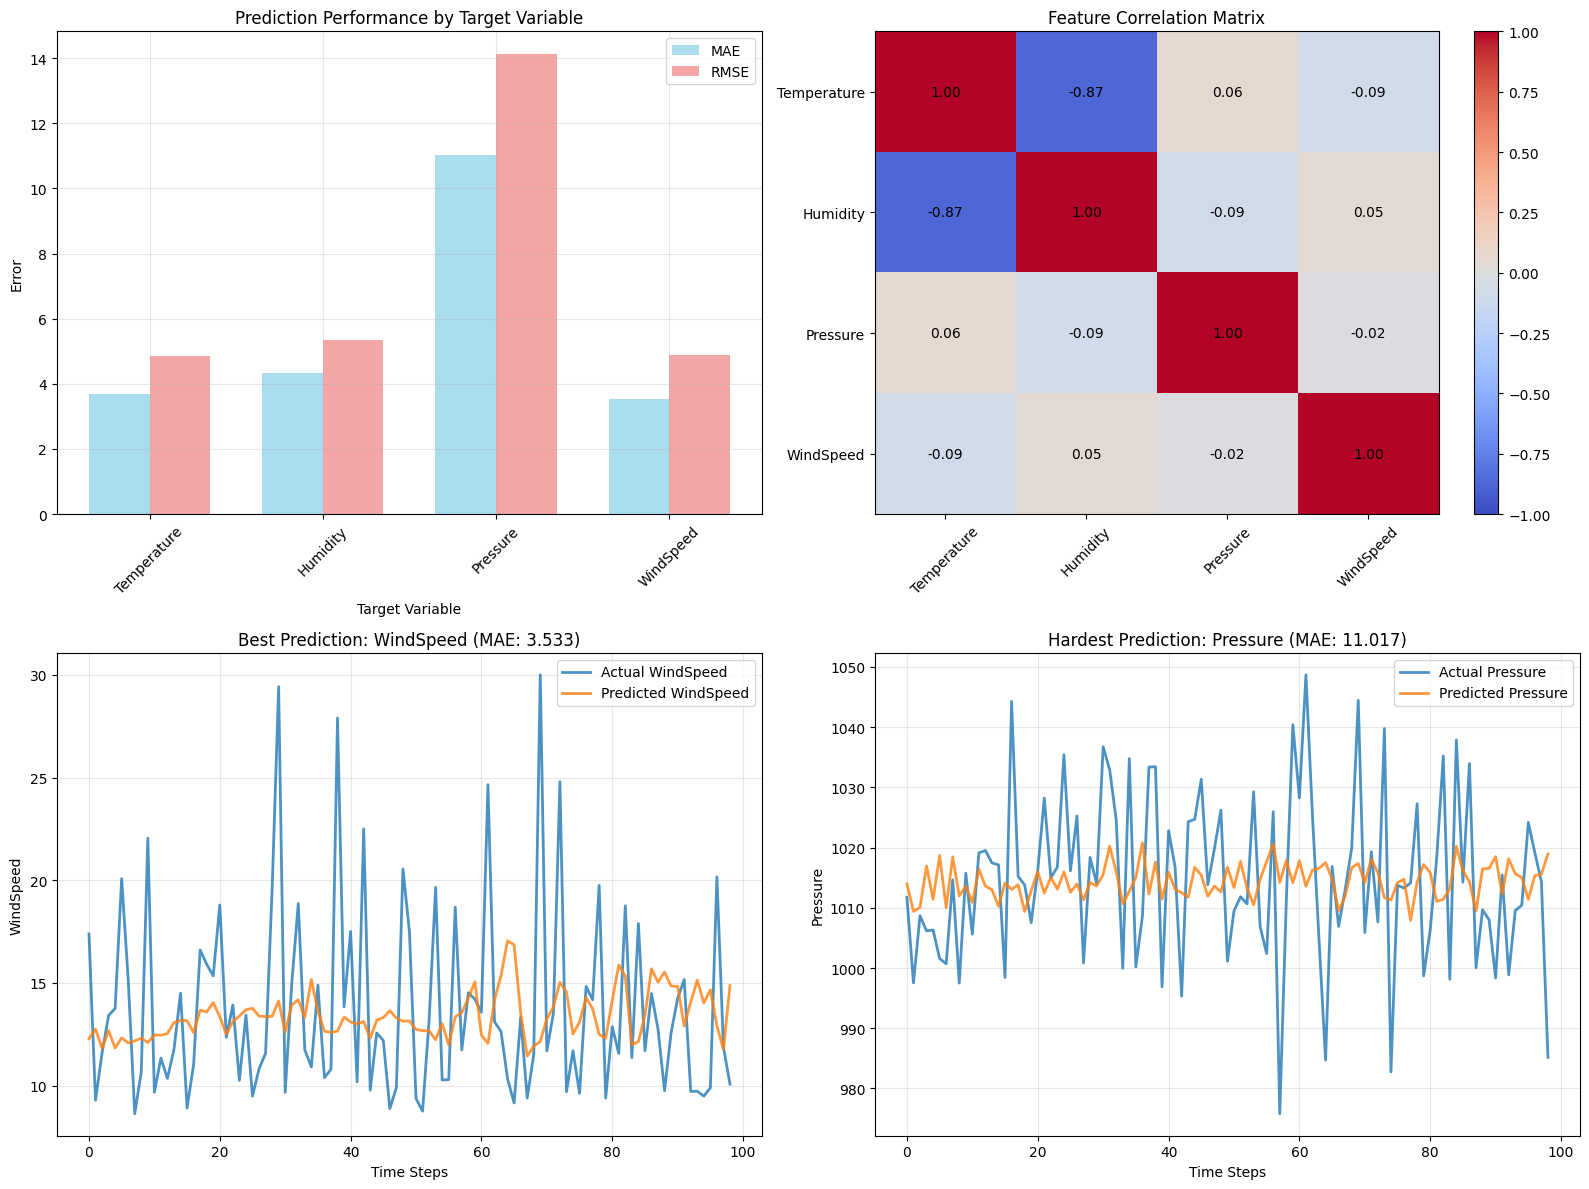

In [11]:
# Visualizations for different target predictions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Prediction Performance Comparison
target_names = list(exercise4_results.keys())
maes = [exercise4_results[name]['mae'] for name in target_names]
rmses = [exercise4_results[name]['rmse'] for name in target_names]

x_pos = np.arange(len(target_names))
width = 0.35

ax1.bar(x_pos - width/2, maes, width, label='MAE', alpha=0.7, color='skyblue')
ax1.bar(x_pos + width/2, rmses, width, label='RMSE', alpha=0.7, color='lightcoral')

ax1.set_title('Prediction Performance by Target Variable')
ax1.set_xlabel('Target Variable')
ax1.set_ylabel('Error')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(target_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Correlation Matrix Heatmap
correlation_data = weather_data[['Temperature', 'Humidity', 'Pressure', 'WindSpeed']].corr()
im = ax2.imshow(correlation_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax2.set_title('Feature Correlation Matrix')
ax2.set_xticks(range(len(correlation_data.columns)))
ax2.set_yticks(range(len(correlation_data.columns)))
ax2.set_xticklabels(correlation_data.columns, rotation=45)
ax2.set_yticklabels(correlation_data.columns)

# Add correlation values to heatmap
for i in range(len(correlation_data.columns)):
    for j in range(len(correlation_data.columns)):
        ax2.text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                ha='center', va='center', fontsize=10)

plt.colorbar(im, ax=ax2)

# Plot 3: Best and Worst Predictions
best_target, best_results = sorted_targets[0]
worst_target, worst_results = sorted_targets[-1]

ax3.plot(best_results['actual'], label=f'Actual {best_target}', linewidth=2, alpha=0.8)
ax3.plot(best_results['predictions'], label=f'Predicted {best_target}', linewidth=2, alpha=0.8)
ax3.set_title(f'Best Prediction: {best_target} (MAE: {best_results["mae"]:.3f})')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel(best_target)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(worst_results['actual'], label=f'Actual {worst_target}', linewidth=2, alpha=0.8)
ax4.plot(worst_results['predictions'], label=f'Predicted {worst_target}', linewidth=2, alpha=0.8)
ax4.set_title(f'Hardest Prediction: {worst_target} (MAE: {worst_results["mae"]:.3f})')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel(worst_target)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Exercise 4 Final Analysis and Insights**

Purpose: Provides comprehensive insights about predicting different weather variables, including domain knowledge and lessons about problem difficulty variation.

In [12]:
# Final analysis and insights
print("\n" + "=" * 60)
print(" EXERCISE 4 ANALYSIS & INSIGHTS")
print("=" * 60)

print(f" EASIEST TO PREDICT: {best_target}")
print(f"    MAE: {best_results['mae']:.3f}")
print(f"    Why: Likely has strong correlations with other variables")

print(f"\n HARDEST TO PREDICT: {worst_target}")
print(f"    MAE: {worst_results['mae']:.3f}")
print(f"    Why: May have more random/chaotic behavior")

print(f"\n RANKING BY PREDICTABILITY:")
for i, (target_name, results) in enumerate(sorted_targets, 1):
    print(f"   {i}. {target_name}: MAE = {results['mae']:.3f}")

print(f"\n KEY INSIGHTS:")
print(f"   🔹 Different weather variables have different predictability")
print(f"   🔹 Variables with strong correlations are easier to predict")
print(f"   🔹 Model performance varies significantly by target type")
print(f"   🔹 Same model architecture works for different prediction tasks")

print(f"\n DOMAIN INSIGHTS:")
if 'Temperature' in exercise4_results and 'WindSpeed' in exercise4_results:
    temp_mae = exercise4_results['Temperature']['mae']
    wind_mae = exercise4_results['WindSpeed']['mae']
    if temp_mae < wind_mae:
        print(f"   🔹 Temperature is more predictable than wind speed (expected)")
        print(f"   🔹 Wind patterns are more chaotic and harder to model")

print(f"   🔹 Humidity often correlates with temperature (weather physics)")
print(f"   🔹 Pressure changes can be gradual and somewhat predictable")

print(f"\n LEARNING POINTS:")
print(f"    Problem difficulty varies by target variable")
print(f"    Feature correlation affects prediction quality")
print(f"    Same model can tackle different prediction tasks")
print(f"    Domain knowledge helps interpret results")
print(f"    Some variables are inherently harder to predict")

print(f"\n EXERCISE 4 COMPLETED!")



 EXERCISE 4 ANALYSIS & INSIGHTS
 EASIEST TO PREDICT: WindSpeed
    MAE: 3.533
    Why: Likely has strong correlations with other variables

 HARDEST TO PREDICT: Pressure
    MAE: 11.017
    Why: May have more random/chaotic behavior

 RANKING BY PREDICTABILITY:
   1. WindSpeed: MAE = 3.533
   2. Temperature: MAE = 3.697
   3. Humidity: MAE = 4.336
   4. Pressure: MAE = 11.017

 KEY INSIGHTS:
   🔹 Different weather variables have different predictability
   🔹 Variables with strong correlations are easier to predict
   🔹 Model performance varies significantly by target type
   🔹 Same model architecture works for different prediction tasks

 DOMAIN INSIGHTS:
   🔹 Humidity often correlates with temperature (weather physics)
   🔹 Pressure changes can be gradual and somewhat predictable

 LEARNING POINTS:
    Problem difficulty varies by target variable
    Feature correlation affects prediction quality
    Same model can tackle different prediction tasks
    Domain knowledge helps interpre